In [1]:
from __future__ import division
import os
import sys
from scipy import integrate

import numpy as np
from numpy import pi,sin,cos,tan,e,arctan,arcsin,arccos,sqrt
from numpy.random import randn
import matplotlib
import matplotlib.pyplot as P



matplotlib.rcParams['figure.figsize'] = (7, 5)
P.rcParams['text.usetex'] = True  # not really needed
P.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
P.rcParams["font.size"] = 24
P.rc('xtick', labelsize=18) 
P.rc('ytick', labelsize=18)
# P.rc('xtick', labelsize=20) 
# P.rc('ytick', labelsize=20)
np.set_printoptions(threshold=np.nan)


sys.path.append("/Users/amadeus/Documents/10.semester/ma")
from magmod import P_cdm_BBKS, D_z, rCom, H_0, c, H_z, E_z, Omega_m, W_tophat, T_obs, nutoz21

sigma_8_BBKS = 0.833959881058


In [80]:
#preliminary, to be changed!!
bHI = 1
bgal = 1

lmin = 250; lmax = 25000 # lmin and lmax for Cl calculation
# lmin = 1; lmax = 1000 # lmin and lmax for Cl calculation
# ltab = np.arange(lmin,lmax)
ltab = np.arange(lmin,lmax, 100)

zf = 0.75
dzf = 0.25
zfmin = zf - dzf; zfmax = zf + dzf

zb = (1.5 + 1.9)/2
dzb = 1.9 - zb
zbmin = zb - dzb; zbmax = zb + dzb

print "foreground from {} to {}".format(zfmin, zfmax)
print "background from {} to {}".format(zbmin, zbmax)

foreground from 0.5 to 1.0
background from 1.5 to 1.9


Some functions as defined in Alkistis' notes:

In [81]:
def sg(z): #number count slope. Fit taken from eq 23 in 1611.01322v2
    n0 = 0.132
    n1 = 0.259
    n2 = 0.281
    n3 = 0.691
    n4 = 0.409
    n5 = 0.152
    
    return n0 + n1*z + n2*z**2 + n3*z**3 + n4*z**4 + n5*z**5
    


def g(z,zb, dzb): #lensing kernel
    """zb is background redshift"""
    zmin = zb - dzb
    zmax = zb + dzb
    integral = integrate.quad(lambda zint: 
                              (rCom(zint) - rCom(z))/rCom(zint) * W_tophat(zint, zmin, zmax)
                              ,z
                              ,zmax,
                              full_output=1)[0]
    return rCom(z) * integral

#difficult to do quick integration because integration limit appears inside the integral:
# def g_cumtrapz(z, zb, dzb, NINT = 2000):
#     """zb is background redshift"""
#     zmin = zb - dzb
#     zmax = zb + dzb
#     z = np.atleast_1d(z)
#     if (z<1e-3).any() or (z>zmax).any():
#         raise ValueError("z lies outside the implemented range")
#     zint = np.linspace(1e-3, zmax, NINT)
#     integrand = (rCom(zint) - rCom(z))/rCom(zint) * W_tophat(zint, zmin, zmax)
#     result = cumtrapz(integrand, aaa, initial=0.)
#     val = interp1d(aaa[::-1], result[::-1], kind='linear', bounds_error=False)
#     return -c*val(a) #units: Mpc


def Cl_HIxmag(ltable, zf, zb, delta_zf, Nint = 500):
    fac1 = 3/2 * H_0/c * Omega_m
    fac2 = bHI * (5*sg(zb) - 2)
    zmin = zf - delta_zf
    zmax = zf + delta_zf
    ztab = np.linspace(zmin, zmax, Nint) #do checks on this! should be 0 to inf
    gtab = [g(zz, zb, dzb) for zz in ztab] # this is slow
    
    integrand=np.zeros([len(ztab),len(ltable)])
    for il in range(len(ltable)):
        ell = ltable[il]
        integrand[:,il]= (1+ztab) / E_z(ztab) * W_tophat(ztab, zfmin, zfmax) * gtab / rCom(ztab)**2 * P_cdm_BBKS(( ell + 1/2)/rCom(ztab)) * D_z(ztab)**2
    result= fac1 * fac2 * np.trapz(integrand,ztab,axis=0)
    return result
    
                        

Galaxy and HI autocorrelation Cls:

In [82]:
def C_l_BBKS_HIHI(ltable,zmin,zmax, Nint = 500):
    """arguments: ell array, zmin, zmax
    returns: Cl as array"""
    ztable = np.linspace(zmin, zmax, Nint)
    integrand=np.zeros([len(ztable),len(ltable)])
    for l in range(len(ltable)):
        integrand[:,l]=E_z(ztable)*(W_tophat(ztable,zmin,zmax)*T_obs(ztable)*D_z(ztable)/rCom(ztable))**2*P_cdm_BBKS((ltable[l]+1/2)/rCom(ztable))
    result=bHI* H_0/c*np.trapz(integrand,ztable,axis=0)
    return result


def C_l_BBKS_gg(ltable,zmin,zmax, Nint = 500):
    """arguments: ell array, zmin, zmax
    returns: Cl as array"""
    ztable = np.linspace(zmin, zmax, Nint)
    integrand=np.zeros([len(ztable),len(ltable)])
    for l in range(len(ltable)):
        integrand[:,l]=E_z(ztable)*(W_tophat(ztable,zmin,zmax)*D_z(ztable)/rCom(ztable))**2*P_cdm_BBKS((ltable[l]+1/2)/rCom(ztable))
    result=bgal* H_0/c*np.trapz(integrand,ztable,axis=0)
    return result


Signal to noise:

In [102]:
def DELTA_Cl_HIxmag(ltable, zf, dzf, zb, dzb, PERFECT_SURVEY = 1):
    zfmin = zf - dzf; zfmax = zf+dzf
    zbmin = zb-dzb; zbmax = zb+dzb
    
    #perfect survey:
    if PERFECT_SURVEY:
        Cshot = np.zeros(len(ltable)); N_ell = np.zeros(len(ltable)); 
        fsky = 1; d_ell = 1;
    
    else:
        return ValueError("only perfect survey implemented")
    X2 = Cl_HIxmag(ltable, zf, zb, dzf)**2
    HIHI = C_l_BBKS_HIHI(ltable, zfmin, zfmax) + Cshot
    gg = C_l_BBKS_gg(ltable, zbmin, zbmax) + N_ell
    num = X2 + HIHI*gg
    denom = (2*ltable+1) * d_ell * fsky
    return np.sqrt(num/denom)

def S2N(ltable, zf, dzf, zb, dzb, PERFECT_SURVEY = 1):
    delt = DELTA_Cl_HIxmag(ltable, zf, dzf, zb, dzb, PERFECT_SURVEY = PERFECT_SURVEY)
    signal = Cl_HIxmag(ltable, zf, zb, dzb)
    return signal/delt

Compare HIHI Cls with Fig 2 in Bingo paper:

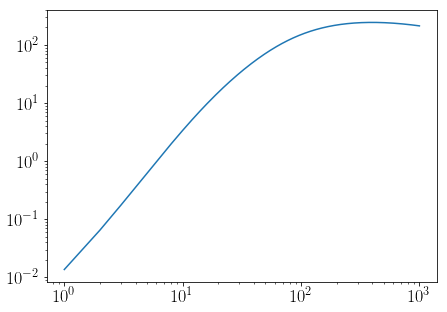

In [83]:
#compare with Fig 2 in Bingo paper:
lbing = np.arange(1,1000)

Cl_HIHI = C_l_BBKS_HIHI(lbing, nutoz21(975), nutoz21(925))


fig = P.figure(); ax = fig.add_subplot(111);
ax.loglog(lbing, Cl_HIHI*(lbing+1)*lbing / 2 / pi)


which matches perfectly.
Now plotting the HI-mag Cls from Alkistis' notes:

In [84]:
Cl_Hxm = Cl_HIxmag(ltab, zf, zb, dzf)
# Cl_gg = Cl_BBKS_gg(ltab, zfmin, zfmax)

Text(0,0.5,u'$C_\\ell^\\mathrm{HI, \\mu} \\ell^2/(2\\pi)$')

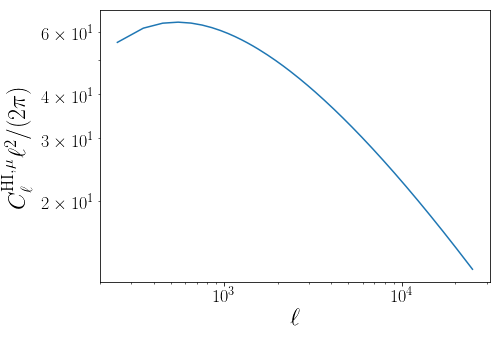

In [94]:
fig = P.figure(); ax = fig.add_subplot(111);
ax.loglog(ltab, Cl_Hxm*ltab**2 / 2 / pi)
ax.set_xlabel("$\ell$")
ax.set_ylabel("$C_\ell^\mathrm{HI, \mu} \ell^2/(2\pi)$")
# ax.plot(ltab, Cl_Hxm*ltab**2/2/pi)

I think our $C_\ell^\mathrm{HI, mag}$ should match $C_\ell^{\mu g}$ Fig. 5 in Zhang&Pen up to a constant factor... However, the $\ell$ dependence is totally different. They peak at around $\ell = 10^4$ whereas this peaks below $10^3$.

Their $\ell$ dependece is $C_\ell^{\mu g} \sim \Delta_m^2(\ell/r(z_f), z_f) / l^3$.

For us it's $C_\ell^\mathrm{HI, mag} \sim P((\ell + 1/2)/r(z),z))$. Here I used the fit from BBKS: $P_m^\mathrm{BBKS}(k) = Ak^{n_s}T_\mathrm{BBKS}(k)$ and thus $P_m^\mathrm{BBKS}(k) \mathrm D^2(z) = P(k,z)$ with the growth factor $D$. As far as I know usual conventions are $P \sim k^3 \Delta$, so where does the $\Delta^2$ come from? I guess it's just another convention but haven't checked yet.

To summarize, I don't know how Zhang-Pen can make their $C_\ell^{\mu g}\ell^2$ peak at around $\ell \sim 10^4$, and I think that our $\ell$ dependence should be exactly the same. Also, the power spectrum I use is correct (checked against the bingo paper).

NOW: signal to noise for perfect survey:

In [106]:
S2N_p_tab = S2N(ltab, zf, dzf, zb, dzb, PERFECT_SURVEY=1)
Delta_Cl_p_tab = DELTA_Cl_HIxmag(ltab, zf, dzf, zb, dzb, PERFECT_SURVEY=1)
print zf, dzf, zb, dzb

0.75 0.25 1.7 0.2


Text(0.5,0,u'$\\ell$')

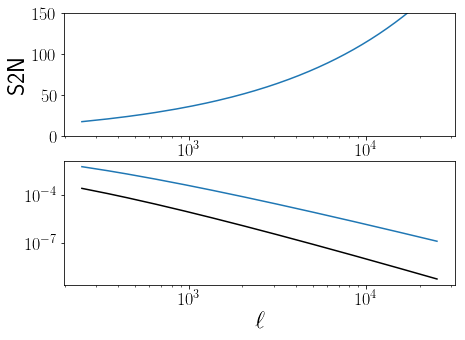

In [111]:
fig = P.figure(); ax1 = fig.add_subplot(211); 
ax2 = fig.add_subplot(212, sharex = ax1);
ax1.semilogx(ltab, S2N_p_tab)
ax1.set_ylim((0.1, 150))
ax1.set_ylabel("S2N")

ax2.loglog(ltab, Cl_Hxm)
ax2.loglog(ltab, Delta_Cl_p_tab, color = 'black')

ax2.set_xlabel("$\ell$")
